# Tensorflow modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

import tensorflow as tf

## 1, Load the data

In [2]:
#from tensorflow import keras
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/Data/vattenfall_turbine.csv')
#drive.flush_and_unmount()
#print('NB: Unmount the google cloud driver')

import numpy as np

df = pd.read_csv('vattenfall_turbine.csv')
keys = df.keys().values
feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
time_key = keys[0]

FileNotFoundError: [Errno 2] No such file or directory: 'vattenfall_turbine.csv'

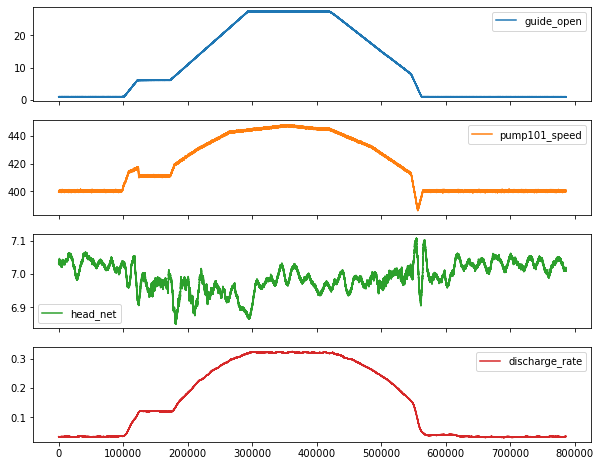

<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>

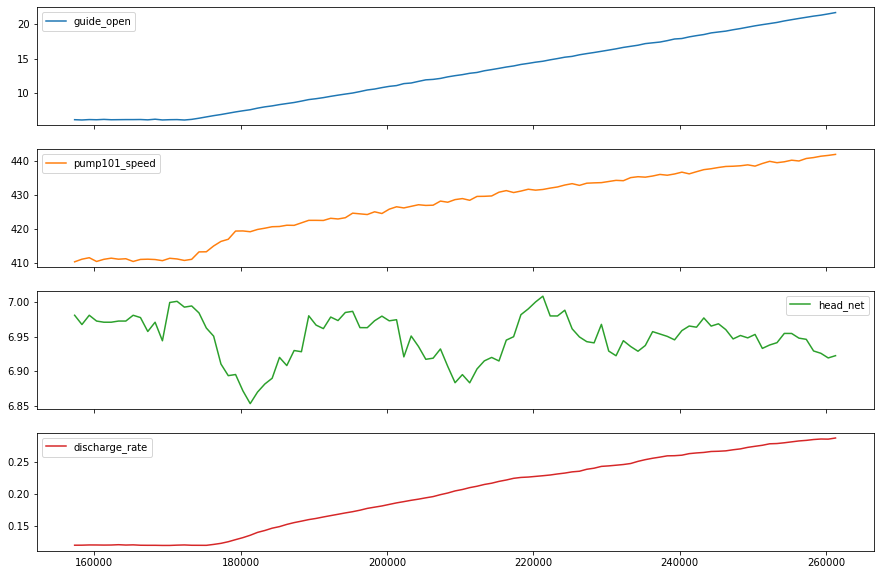

In [13]:
plot_cols = feature_keys[0:len(feature_keys):2]
plot_features = df[plot_cols]
#plot_features.index = df[time_key]
fig1 = plot_features.plot(subplots=True, figsize=(10, 8))
plt.show()

from IPython.display import display, Markdown
#display(Markdown(' <font size="6"><span style="color:blue">**Lets take a close look at the time series.**</span> </font>'))

display(Markdown('<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>'))

plot_features = df[plot_cols][int(len(df)/5):int(len(df)/3):1000]
#plot_features.index = df[time_key][:480]
fig2 = plot_features.plot(subplots=True, figsize=(15, 10))

## 2, Preprocessing data: normalize, train, validation, test, etc.

### 2.1, resample the data with low-resolution

df_train = df[feature_keys[0:7:2]][int(len(df)/4):int(len(df)/2):100]
display(Markdown('<span style="color:red; font-size:30px">**No. of the values in the training dataset is: %d**</span>' %len(df_train)))

# plot the data and check their variations along time
df_train.plot(subplots=True, figsize=(15, 10))
plt.show()
#print('No. of the values in the training dataset is: %d' %len(df_train))

display(Markdown('<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>'))
# check he correlation
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f")
plt.show()

### 2.2, autocorrelation function (ACF) and (PACF) to check time dependence

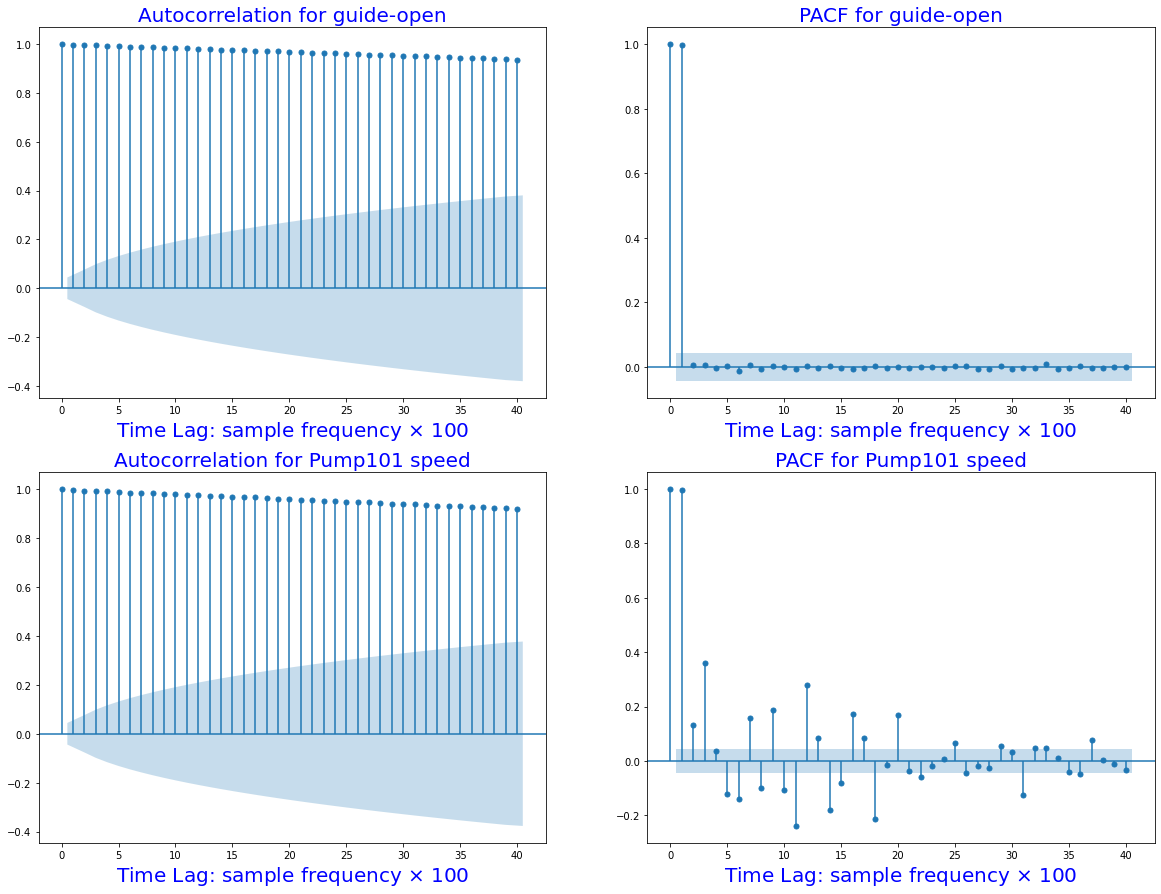

In [101]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

acf_open = autocorr(df_train.guide_open)


from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

fig, ax = plt.subplots(2,2,figsize=(20,15))
sm.graphics.tsa.plot_acf(df_train.guide_open.squeeze(), lags=40, ax=ax[0,0])
ax[0,0].set_title("Autocorrelation for guide-open", fontsize=20, color='blue')
ax[0,0].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_pacf(df_train.guide_open.squeeze(), lags=40, ax=ax[0, 1])
ax[0,1].set_title("PACF for guide-open", fontsize=20, color='blue')
ax[0,1].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_acf(df_train.pump101_speed.squeeze(), lags=40, ax=ax[1,0])
ax[1,0].set_title("Autocorrelation for Pump101 speed", fontsize=20, color='blue')
ax[1,0].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_pacf(df_train.pump101_speed.squeeze(), lags=40, ax=ax[1,1])
ax[1,1].set_title("PACF for Pump101 speed", fontsize=20, color='blue')
ax[1,1].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')
plt.show()

### 2.3 crossing autocorrelationship for various parameters

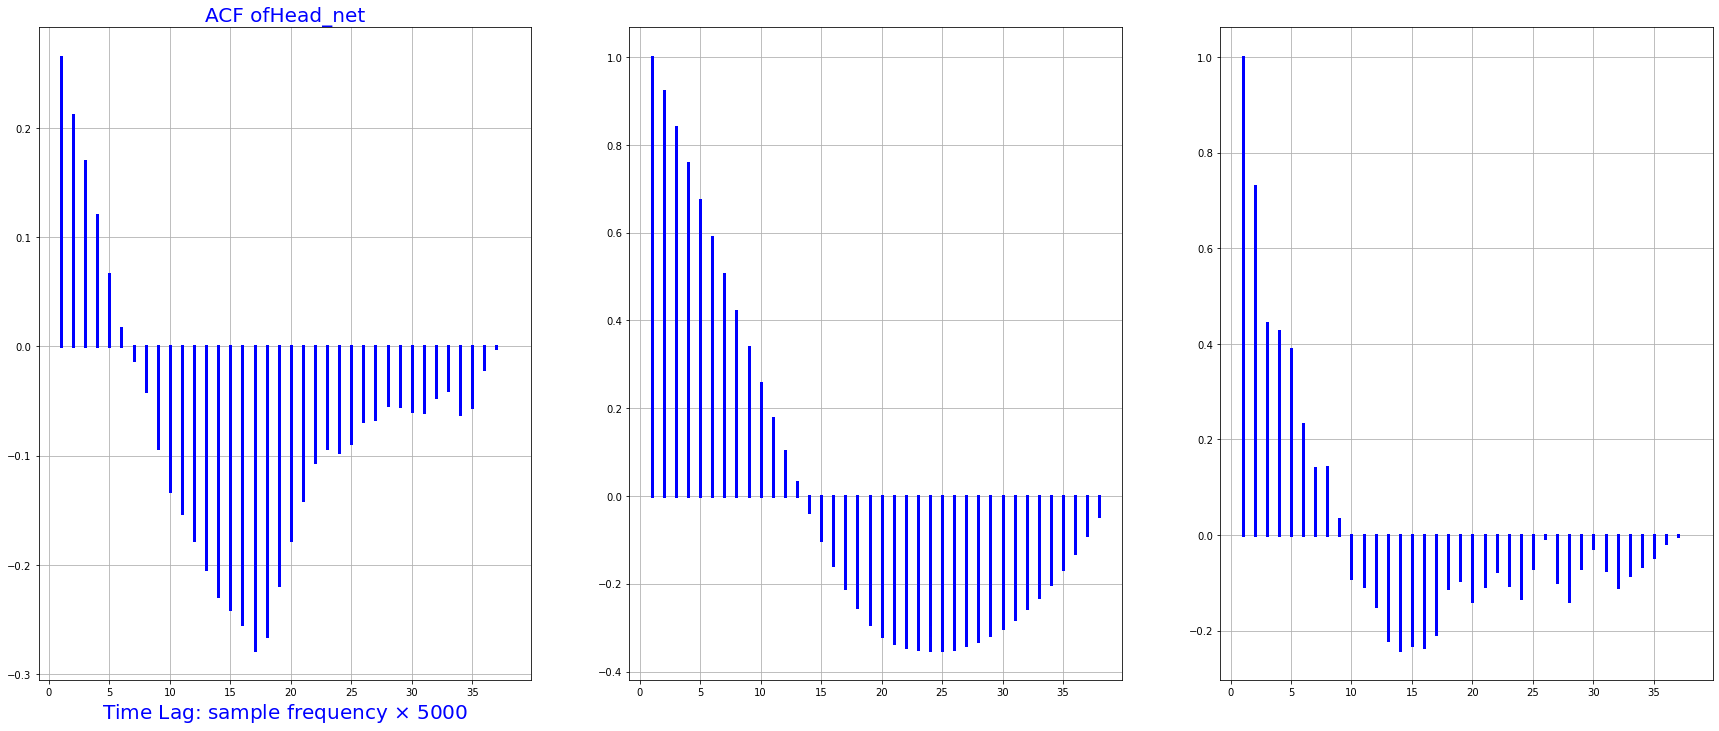

In [151]:
# NB: we have resampled the data for the autocorreltion analysis

import statsmodels.tsa.stattools as smt
xacf = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.head_net.squeeze()[0:1900:50],  adjusted=False)
acf1 = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.guide_open.squeeze()[0:1900:50],  adjusted=False)
acf2 = smt.ccf(df_train.head_net.squeeze()[0:1900:50], df_train.head_net.squeeze()[0:1900:50],  adjusted=False)


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharex=True, figsize=(30,12))
i = 1
for p in xacf:
    x = [i, i]
    ax1.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax1.grid(True)
ax1.set_title("Cross ACF between guide-open and Head_net", fontsize=20, color='blue')
ax1.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')


i = 1
for p in acf1:
    x = [i, i]
    ax2.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax2.grid(True)
ax2.set_title("ACF of guide-open signal", fontsize=20, color='blue')
ax2.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')

i = 1
for p in acf2:
    x = [i, i]
    ax3.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax3.grid(True)
ax3.set_title("ACF ofHead_net", fontsize=20, color='blue')
ax4.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')

plt.show()

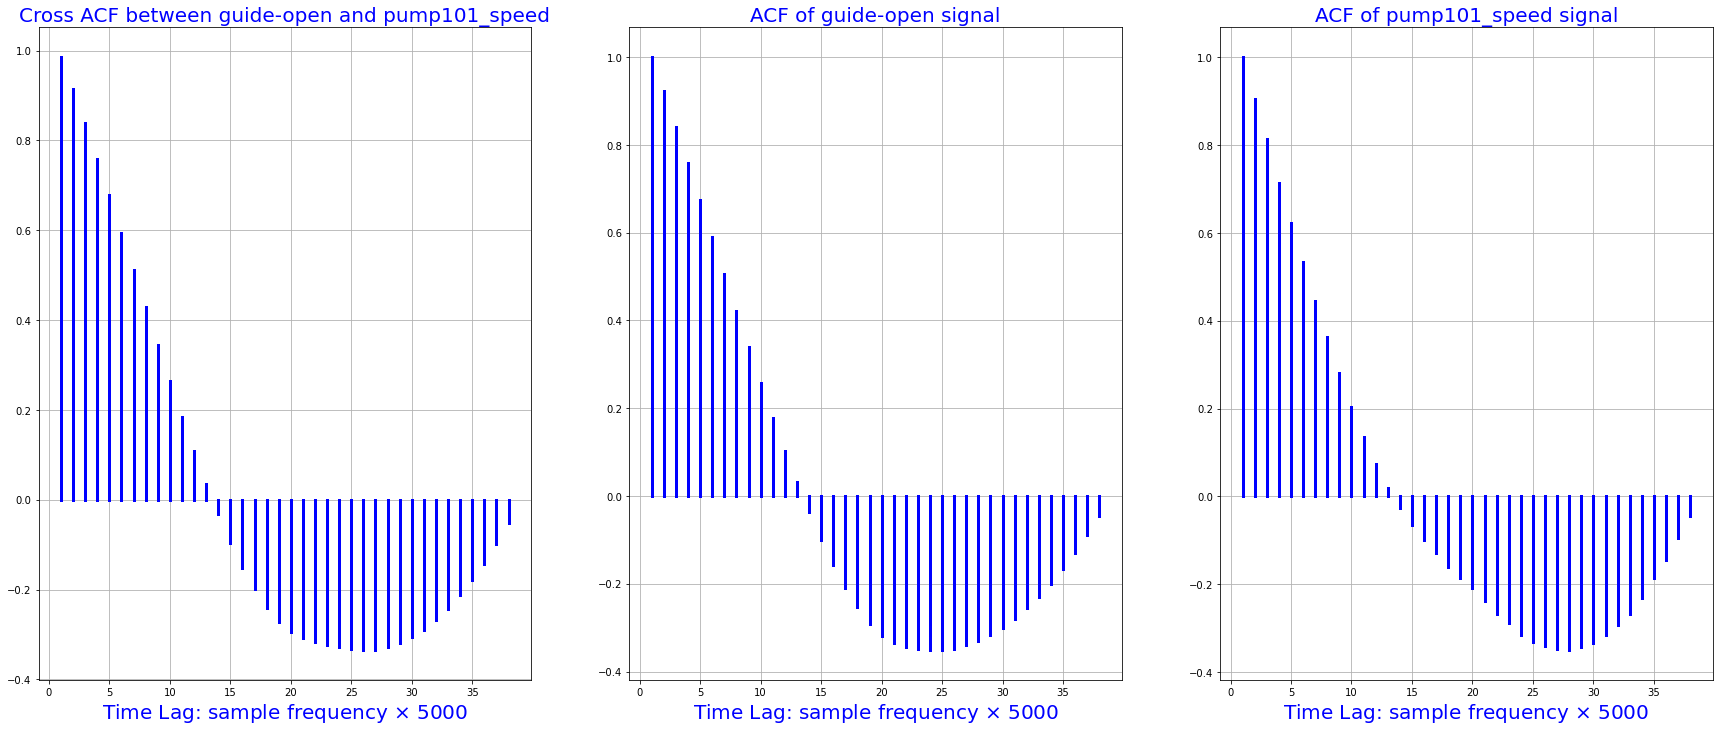

In [152]:
# Autocorrelation between guide_opan and pump101_speed
xacf = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.pump101_speed.squeeze()[0:1900:50],  adjusted=False)
acf1 = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.guide_open.squeeze()[0:1900:50],  adjusted=False)
acf2 = smt.ccf(df_train.pump101_speed.squeeze()[0:1900:50], df_train.pump101_speed.squeeze()[0:1900:50],  adjusted=False)


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharex=True, figsize=(30,12))
i = 1
for p in xacf:
    x = [i, i]
    ax1.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax1.grid(True)
ax1.set_title("Cross ACF between guide-open and pump101_speed", fontsize=20, color='blue')
ax1.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')


i = 1
for p in acf1:
    x = [i, i]
    ax2.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax2.grid(True)
ax2.set_title("ACF of guide-open signal", fontsize=20, color='blue')
ax2.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')



i = 1
for p in acf2:
    x = [i, i]
    ax3.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax3.grid(True)
ax3.set_title("ACF of pump101_speed signal", fontsize=20, color='blue')
ax3.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')



plt.show()

### 2.3, normalize the data

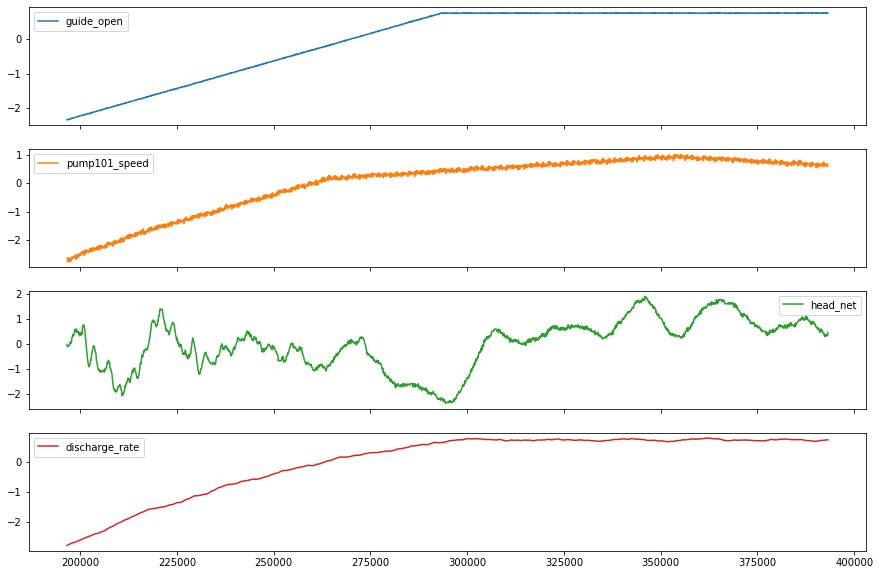

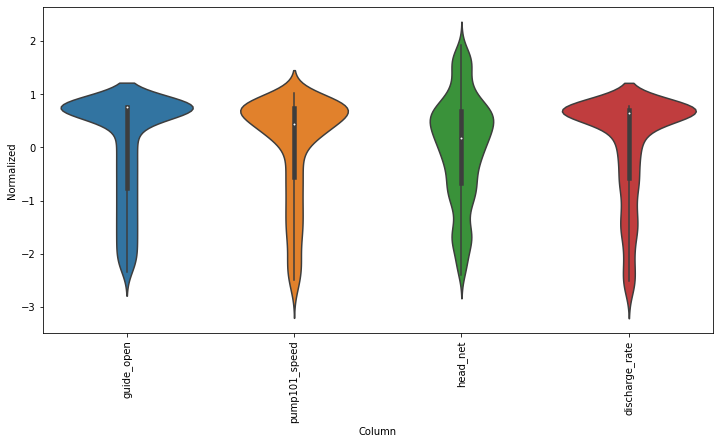

In [15]:
# First, we assume all data are used for the training (the time series is not that stationary for the prediction)
df_train_mean = df_train.mean()
df_train_std = df_train.std()
train_df = (df_train-df_train_mean) / df_train_std

fig2 = train_df.plot(subplots=True,figsize=(15,10))

# Second, plot the standand deviation of features within this dataframe
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
fig3 = ax.set_xticklabels(train_df.keys(), rotation=90)

In [42]:
# tf.convert_to_tensor(new_df)
new_df = train_df.reset_index(drop=True)
target = new_df.pop('guide_open')
#new_df.head()
target.head()
new_df = tf.convert_to_tensor(new_df)

#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(numeric_features)

In [50]:
tf.data.Dataset.from_tensor_slices(new_df)

<TensorSliceDataset shapes: (3,), types: tf.float64>

## Test the functions of the tf.data.Dataset for slice data to formulate rolling windowed dataset

In [199]:
test = tf.data.Dataset.from_tensor_slices(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 196607 to 393207
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   guide_open      1967 non-null   float64
 1   pump101_speed   1967 non-null   float64
 2   head_net        1967 non-null   float64
 3   discharge_rate  1967 non-null   float64
dtypes: float64(4)
memory usage: 61.6 KB


## <span style ="color:blue; font-size:25px"> **3, NB: get the rolling/windowed dataset**</span>

In [96]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """Function for creating a windowed dataset for sequence training"""
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [132]:
series = np.random.normal(0, 1, 19)
series


array([-0.29050317,  0.11212805,  1.25079512, -1.36088997,  0.09993288,
       -0.0479911 , -0.35622969, -1.08855909, -0.3510177 ,  2.58839995,
       -0.50565079, -0.58430921, -1.27309938,  0.74678304, -0.55834612,
       -0.11080156, -1.18733663, -1.00822592, -0.68986173])

In [187]:
data = np.array(train_df.guide_open, dtype=np.float32)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 3
window_size = 80
batch_size = 150
train_set  = windowed_dataset(data, window_size, batch_size, shuffle_buffer_size)
n = 0
for window in train_set:
    n = n +1
    print(window)

display(Markdown('<span style="color:blue; font-size:20px">The windowed size is: %d, and raw datashape is (%d)</span>'%(n, data.shape[0])))

#(f'The windowed size and raw datashape:{n, data.shape}')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(<tf.Tensor: shape=(150, 80), dtype=float32, numpy=
array([[-2.3410695, -2.3477952, -2.3309808, ..., -2.0975974, -2.0834734,
        -2.087509 ],
       [-2.3329988, -2.3235826, -2.3329988, ..., -2.0807831, -2.0747302,
        -2.0733848],
       [-2.3477952, -2.3309808, -2.3329988, ..., -2.0834734, -2.087509 ,
        -2.0807831],
       ...,
       [-1.8729576, -1.8695947, -1.8716123, ..., -1.63

<span style="color:blue; font-size:20px">The windowed size is: 13, and raw datashape is (1967)</span>

In [ ]:
def get_basic_model():
  model = tf.keras.Sequential([
    tf.data.Dataset.from_tensor_slices(new_df),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

model = get_basic_model()
model.add(new_df.layers[0])
model.fit(tf.data.Dataset.from_tensor_slices(new_df), target, epochs=3, batch_size=BATCH_SIZE)

TypeError: The added layer must be an instance of class Layer. Found: <TensorSliceDataset shapes: (3,), types: tf.float64>

## **4, Model construction**

In [193]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size = 5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation ="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
                                    ])

#input_shape=[None, 1]
#model.build(input_shape)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [184]:
optimizer = tf.keras.optimizers.SGD(lr=1e-3,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer = optimizer, metrics=["mae"])
history = model.fit(train_set, epochs = 5)

Epoch 1/5


ValueError: in user code:

    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Public\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, None]
